In [33]:
import sys
import pickle
import nltk
from nltk.stem import PorterStemmer
import torch.nn.functional as F
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
sys.path.insert(0, '..')
from nltk.tokenize import word_tokenize
ps = PorterStemmer()
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gxb18167\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
with open('EEG_Text_Pairs.pkl', 'rb') as file:
    EEG_word_level_embeddings = pickle.load(file)
    train_data = pickle.load(file)

In [35]:
with open('Target_Pred_Stringsrandom_2.pickle', 'rb') as f:
    data = pickle.load(f)

In [36]:
target_string_list = data['Target_String']

In [37]:
predicted_string_list = data['Predicted_String']

In [38]:
def get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=False):
    Correct_Predictions = {}
    Incorrect_Predictions = {}
    counter_list = []

    train_string = " ".join(train_data)
    train_string_tokenized = word_tokenize(train_string)

    if stemming == True:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(ps.stem(w))
    else:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(w)



    for i in range(len(target_string_list)):
        target_string = target_string_list[i]
        predicted_string = predicted_string_list[i]

        predicted_string = predicted_string[0:len(target_string)]

        target_tokenized = word_tokenize(target_string)

        #print(target_tokenized)
        predicted_tokenized = word_tokenize(predicted_string)

        if stemming == True:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(ps.stem(w))
                counter_list.append(ps.stem(w))
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(ps.stem(w))
        else:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(w)
                counter_list.append(w)
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(w)

        if strict == False:
            for word in target_tokenized_stemmed:
                if word in predicted_tokenized_stemmed:
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
                else:
                    if word in Incorrect_Predictions:
                        Incorrect_Predictions[word] += 1
                    else:
                        Incorrect_Predictions[word] = 1
        else:
            min_length = min(len(predicted_tokenized_stemmed), len(target_tokenized_stemmed))
            for i in range(min_length):
                if target_tokenized_stemmed[i] == predicted_tokenized_stemmed[i]:
                    word = target_tokenized_stemmed[i]
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
                else:
                    word = target_tokenized_stemmed[i]
                    if word in Incorrect_Predictions:
                        Incorrect_Predictions[word] += 1
                    else:
                        Incorrect_Predictions[word] = 1



    target_word_counter = Counter(counter_list)
    print(len(target_word_counter))
    word_frequency = Counter(train_string_tokenized_stemmed)
    print(len(word_frequency))

    common_keys = set(target_word_counter.keys()) & set(word_frequency.keys())
    word_frequency = {k: word_frequency[k] for k in common_keys}



    return Correct_Predictions, Incorrect_Predictions, word_frequency


In [39]:
Correct_Predictions, Incorrect_Predictions, word_frequency = get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=False)

873
4027


In [40]:
import re


def calculate_tf(sentences):
    term_frequencies = []

    for sentence in sentences:
        # Preprocess the sentence: convert to lowercase and remove non-alphanumeric characters
        preprocessed_sentence = re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower())

        # Tokenize the sentence into words
        words = preprocessed_sentence.split()

        # Calculate term frequency using Counter
        term_frequency = Counter(words)

        # Normalize term frequency by dividing by the total number of terms in the sentence
        total_terms = len(words)
        normalized_tf = {term: frequency / total_terms for term, frequency in term_frequency.items()}

        term_frequencies.append(normalized_tf)

    return term_frequencies

In [41]:
tf= calculate_tf(target_string_list)

In [42]:
import math


def calculate_idf(sentences):
    # Preprocess each sentence and tokenize into words
    preprocessed_sentences = [re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split() for sentence in sentences]

    # Flatten the list of words to get unique terms
    unique_terms = set([term for words in preprocessed_sentences for term in words])

    # Calculate document frequency for each term
    doc_frequencies = Counter()
    for term in unique_terms:
        for words in preprocessed_sentences:
            if term in words:
                doc_frequencies[term] += 1

    # Calculate IDF for each term
    total_documents = len(sentences)
    idf_results = {term: math.log(total_documents / (1 + doc_frequency)) for term, doc_frequency in doc_frequencies.items()}

    return idf_results

In [43]:
def calculate_tf_idf(sentences):
    # Calculate TF for each term in each sentence
    def calculate_tf(sentence):
        words = re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split()
        term_frequency = Counter(words)
        total_terms = len(words)
        normalized_tf = {term: frequency / total_terms for term, frequency in term_frequency.items()}
        return normalized_tf

    # Calculate IDF for each term across all sentences
    def calculate_idf(sentences):
        preprocessed_sentences = [re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split() for sentence in sentences]
        unique_terms = set([term for words in preprocessed_sentences for term in words])
        doc_frequencies = Counter()
        for term in unique_terms:
            for words in preprocessed_sentences:
                if term in words:
                    doc_frequencies[term] += 1
        total_documents = len(sentences)
        idf_results = {term: math.log(total_documents / (1 + doc_frequency)) for term, doc_frequency in doc_frequencies.items()}
        return idf_results

    # Calculate TF-IDF for each term in each sentence
    tf_idf_results = []
    idf_results = calculate_idf(sentences)
    for sentence in sentences:
        tf = calculate_tf(sentence)
        tf_idf = {term: tf_value * idf_results[term] for term, tf_value in tf.items()}
        tf_idf_results.append(tf_idf)

    return tf_idf_results

In [44]:
def calculate_tf_idf_aggregate(sentences):
    # Calculate TF for each term in each sentence
    def calculate_tf(sentence):
        words = re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split()
        term_frequency = Counter(words)
        total_terms = len(words)
        normalized_tf = {term: frequency / total_terms for term, frequency in term_frequency.items()}
        return normalized_tf

    # Calculate IDF for each term across all sentences
    def calculate_idf(sentences):
        preprocessed_sentences = [re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split() for sentence in sentences]
        unique_terms = set([term for words in preprocessed_sentences for term in words])
        doc_frequencies = Counter()
        for term in unique_terms:
            for words in preprocessed_sentences:
                if term in words:
                    doc_frequencies[term] += 1
        total_documents = len(sentences)
        idf_results = {term: math.log(total_documents / (1 + doc_frequency)) for term, doc_frequency in doc_frequencies.items()}
        return idf_results

    # Calculate TF-IDF for each term in each sentence
    tf_idf_results = []
    idf_results = calculate_idf(sentences)
    for sentence in sentences:
        tf = calculate_tf(sentence)
        tf_idf = {term: tf_value * idf_results[term] for term, tf_value in tf.items()}
        tf_idf_results.append(tf_idf)

    # Aggregate TF-IDF scores for each term across all sentences
    aggregated_scores = Counter()
    for tf_idf in tf_idf_results:
        for term, score in tf_idf.items():
            aggregated_scores[term] += score

    return aggregated_scores

In [45]:
def calculate_idf(sentences):
    preprocessed_sentences = [re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split() for sentence in sentences]
    unique_terms = set([term for words in preprocessed_sentences for term in words])
    doc_frequencies = Counter()
    for term in unique_terms:
        for words in preprocessed_sentences:
            if term in words:
                doc_frequencies[term] += 1
    total_documents = len(sentences)
    idf_results = {term: math.log(total_documents / (1 + doc_frequency)) for term, doc_frequency in doc_frequencies.items()}
    return idf_results

In [46]:
idf = calculate_idf(target_string_list)

In [47]:
dict(sorted(idf.items(), key=lambda item: item[1]))

{'the': 0.5084634348521803,
 'of': 0.8025866379027791,
 'and': 0.8966828866945573,
 'a': 0.8966828866945573,
 'he': 1.0524054377410583,
 'was': 1.079371344005656,
 'in': 1.2557731705655655,
 'to': 1.2833205924066555,
 'his': 1.4802535447459355,
 'is': 1.5878713265404227,
 'as': 1.7747227591068346,
 'an': 1.9010837987789126,
 'that': 1.9488297837206578,
 'with': 2.34339633765808,
 'for': 2.351491362974704,
 'on': 2.3596524528844665,
 'from': 2.3596524528844665,
 'president': 2.4014878898362704,
 'also': 2.641795854074548,
 'born': 2.663766712212087,
 'at': 2.7209033478628912,
 'first': 2.7327331388167826,
 'world': 2.7815034697834493,
 'it': 2.819708455730322,
 'like': 2.8327748437203146,
 'secretary': 2.8460142250979703,
 'one': 2.859431242110275,
 'during': 2.873030726409236,
 'war': 2.8868177094978167,
 'by': 2.9587566762320505,
 'when': 2.9890467253815913,
 'only': 3.004542903236146,
 'after': 3.0525265213301918,
 'this': 3.0525265213301918,
 'played': 3.0525265213301918,
 'comedy':

In [48]:
tf_idf = calculate_tf_idf_aggregate(target_string_list)

In [49]:
tf_idf

Counter({'was': 1052.6725094352269,
         'the': 1032.5041290686556,
         'of': 1016.7427582968929,
         'a': 1014.1576248285404,
         'he': 1011.902057609575,
         'and': 938.7372180742566,
         'in': 878.7308122637282,
         'is': 873.72586405345,
         'an': 835.92357731571,
         'to': 792.5385867147176,
         'as': 735.8912412189865,
         'his': 701.2641479990881,
         'that': 633.3817087041266,
         'from': 602.2706738056704,
         'on': 593.856272724331,
         'at': 577.5175531631245,
         'experience': 536.277336844439,
         'exhilarating': 523.9328259690363,
         'with': 486.8269640763788,
         'for': 480.3486006620286,
         'president': 463.9019100406378,
         'performance': 454.3579313969829,
         'like': 437.99565849286074,
         'played': 430.4062395075542,
         'gone': 416.40289725049723,
         'secretary': 411.58940679491076,
         'but': 396.19123778149486,
         'remarkably

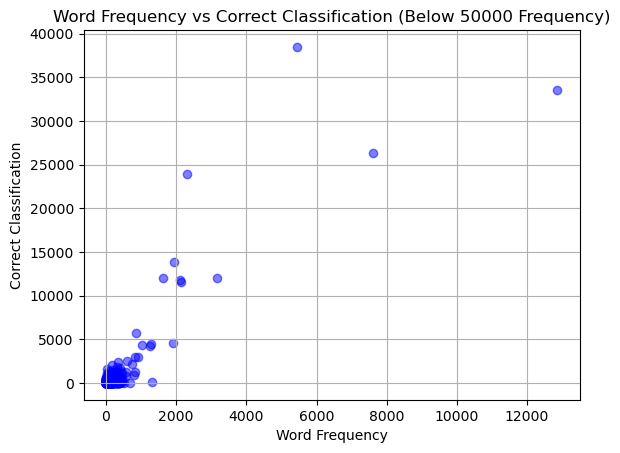

In [50]:
import matplotlib.pyplot as plt
# Extract data for plotting

# Define the frequency threshold
frequency_threshold = 50000

# Filter words based on frequency threshold
filtered_words = [word for word, freq in word_frequency.items() if freq < frequency_threshold]
filtered_frequencies = [word_frequency[word] for word in filtered_words]
filtered_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]

# Create a scatter plot
plt.scatter(filtered_frequencies, filtered_classifications, color='blue', alpha=0.5)

# Customize the plot
plt.title('Word Frequency vs Correct Classification (Below {} Frequency)'.format(frequency_threshold))
plt.xlabel('Word Frequency')
plt.ylabel('Correct Classification')
plt.grid(True)
plt.show()

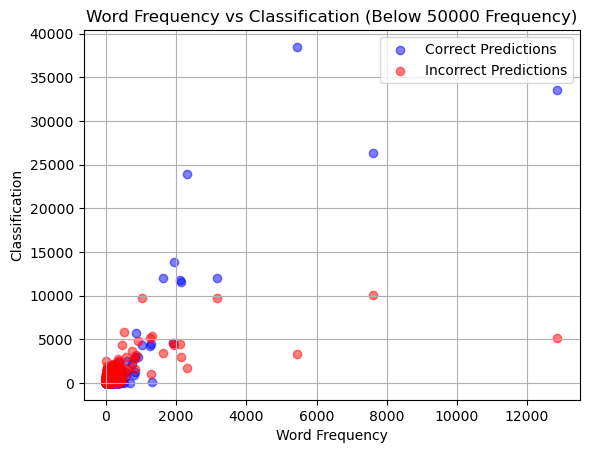

In [51]:
import matplotlib.pyplot as plt

# Extract data for plotting

# Define the frequency threshold
frequency_threshold = 50000

# Filter words based on frequency threshold
filtered_words = [word for word, freq in word_frequency.items() if freq < frequency_threshold]
filtered_frequencies = [word_frequency[word] for word in filtered_words]
filtered_correct_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]
filtered_incorrect_classifications = [Incorrect_Predictions.get(word, 0) for word in filtered_words]

# Create scatter plots for correct and incorrect predictions
plt.scatter(filtered_frequencies, filtered_correct_classifications, color='blue', alpha=0.5, label='Correct Predictions')
plt.scatter(filtered_frequencies, filtered_incorrect_classifications, color='red', alpha=0.5, label='Incorrect Predictions')

# Customize the plot
plt.title('Word Frequency vs Classification (Below {} Frequency)'.format(frequency_threshold))
plt.xlabel('Word Frequency')
plt.ylabel('Classification')
plt.legend()  # Display legend to distinguish between correct and incorrect predictions
plt.grid(True)
plt.show()

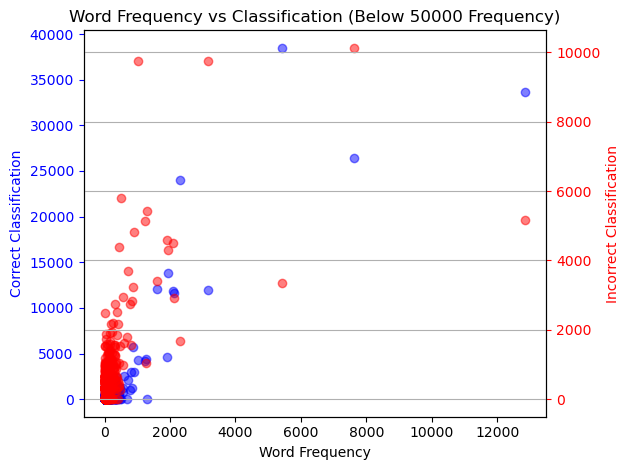

In [52]:
import matplotlib.pyplot as plt

# Extract data for plotting

# Define the frequency threshold
frequency_threshold = 50000

# Filter words based on frequency threshold
filtered_words = [word for word, freq in word_frequency.items() if freq < frequency_threshold]
filtered_frequencies = [word_frequency[word] for word in filtered_words]
filtered_correct_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]
filtered_incorrect_classifications = [Incorrect_Predictions.get(word, 0) for word in filtered_words]

# Create figure and axes
fig, ax1 = plt.subplots()

# Plot correct predictions on the left y-axis
ax1.scatter(filtered_frequencies, filtered_correct_classifications, color='blue', alpha=0.5, label='Correct Predictions')
ax1.set_xlabel('Word Frequency')
ax1.set_ylabel('Correct Classification', color='blue')
ax1.tick_params('y', colors='blue')

# Create a secondary y-axis for incorrect predictions on the right
ax2 = ax1.twinx()
ax2.scatter(filtered_frequencies, filtered_incorrect_classifications, color='red', alpha=0.5, label='Incorrect Predictions')
ax2.set_ylabel('Incorrect Classification', color='red')
ax2.tick_params('y', colors='red')

# Customize the plot
plt.title('Word Frequency vs Classification (Below {} Frequency)'.format(frequency_threshold))
plt.grid(True)
fig.tight_layout()
plt.show()


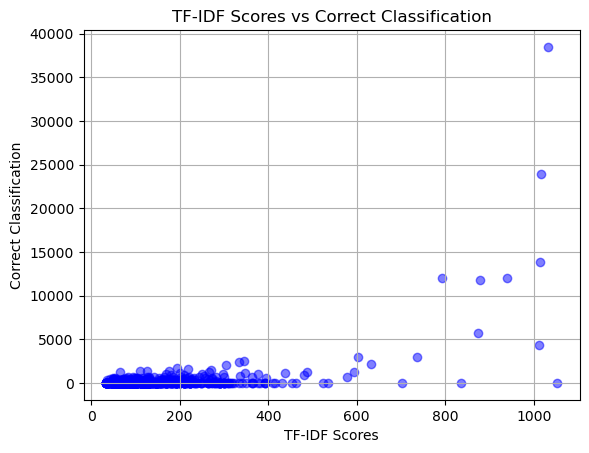

In [53]:
import matplotlib.pyplot as plt

# Extracting words and scores
words = list(tf_idf.keys())
scores = list(tf_idf.values())

# Extracting correct classification values

class_values = [Correct_Predictions.get(word, 0) for word in words]
plt.scatter(scores, class_values, color='blue', alpha=0.5)

# Customize the plot
plt.title('TF-IDF Scores vs Correct Classification')
plt.xlabel('TF-IDF Scores')
plt.ylabel('Correct Classification')
plt.grid(True)
plt.show()

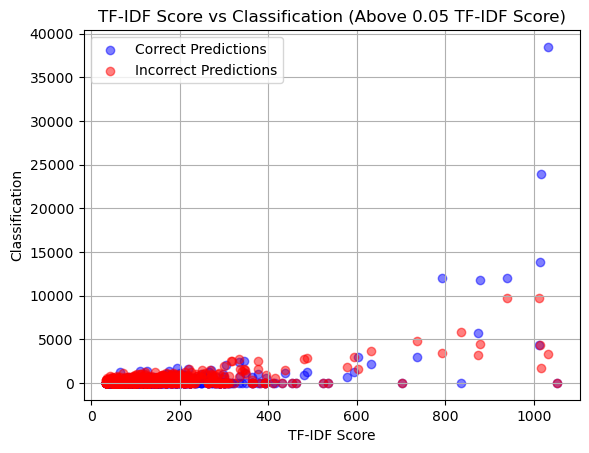

In [54]:

# Define the TF-IDF score threshold
tfidf_threshold = 0.05  # Adjust as needed

# Filter words based on TF-IDF score threshold
filtered_words = [word for word, tfidf in tf_idf.items() if tfidf > tfidf_threshold]
filtered_tfidf_scores = [tf_idf[word] for word in filtered_words]
filtered_correct_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]
filtered_incorrect_classifications = [Incorrect_Predictions.get(word, 0) for word in filtered_words]

# Create figure and axes
fig, ax = plt.subplots()

# Plot correct predictions in blue
ax.scatter(filtered_tfidf_scores, filtered_correct_classifications, color='blue', alpha=0.5, label='Correct Predictions')

# Plot incorrect predictions in red
ax.scatter(filtered_tfidf_scores, filtered_incorrect_classifications, color='red', alpha=0.5, label='Incorrect Predictions')

# Set labels and title
ax.set_xlabel('TF-IDF Score')
ax.set_ylabel('Classification')
plt.title('TF-IDF Score vs Classification (Above {} TF-IDF Score)'.format(tfidf_threshold))

# Customize the plot
plt.legend()
plt.grid(True)
plt.show()

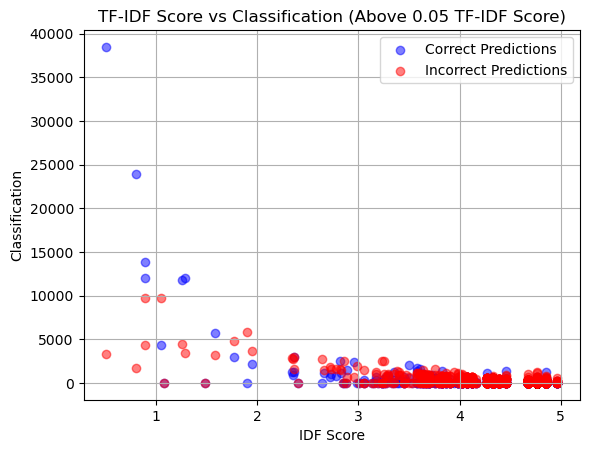

In [55]:

# Define the TF-IDF score threshold
idf_threshold = 0.05  # Adjust as needed

# Filter words based on TF-IDF score threshold
filtered_words = [word for word, idf in idf.items() if idf > idf_threshold]
filtered_tfidf_scores = [idf[word] for word in filtered_words]
filtered_correct_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]
filtered_incorrect_classifications = [Incorrect_Predictions.get(word, 0) for word in filtered_words]

# Create figure and axes
fig, ax = plt.subplots()

# Plot correct predictions in blue
ax.scatter(filtered_tfidf_scores, filtered_correct_classifications, color='blue', alpha=0.5, label='Correct Predictions')

# Plot incorrect predictions in red
ax.scatter(filtered_tfidf_scores, filtered_incorrect_classifications, color='red', alpha=0.5, label='Incorrect Predictions')

# Set labels and title
ax.set_xlabel('IDF Score')
ax.set_ylabel('Classification')
plt.title('TF-IDF Score vs Classification (Above {} TF-IDF Score)'.format(idf_threshold))

# Customize the plot
plt.legend()
plt.grid(True)
plt.show()

In [56]:
Correct_Predictions

{'like': 1184,
 '``': 1260,
 ',': 33596,
 "''": 1855,
 'and': 12011,
 '.': 26385,
 'you': 654,
 'of': 23975,
 'thing': 660,
 'is': 5686,
 'again': 614,
 'most': 660,
 'becaus': 330,
 'it': 2522,
 'name': 330,
 'me': 1,
 'she': 49,
 'her': 14,
 'the': 38481,
 'famili': 630,
 "'s": 4604,
 'new': 300,
 'in': 11843,
 'cultur': 300,
 'much': 300,
 'same': 603,
 'over': 955,
 'as': 3011,
 'to': 12065,
 'team': 330,
 'anoth': 660,
 'day': 330,
 'season': 315,
 'wild': 300,
 'that': 2153,
 'parent': 285,
 'a': 13834,
 'game': 300,
 'keep': 600,
 'pop': 10,
 'your': 299,
 'happen': 515,
 "'": 960,
 'up': 407,
 'on': 1199,
 'after': 325,
 'by': 2398,
 'so': 660,
 'talent': 267,
 'part': 330,
 'dull': 298,
 'at': 690,
 'with': 1201,
 'other': 328,
 'els': 18,
 'been': 601,
 'about': 623,
 'origin': 328,
 'down': 328,
 'all': 330,
 'we': 43,
 'not': 330,
 'they': 330,
 'nor': 330,
 'our': 300,
 'into': 1261,
 'i': 280,
 "'m": 280,
 'idiot': 330,
 'chemistri': 280,
 'their': 1996,
 'romant': 300,
 

In [57]:
Accuracy = {}

for key, value in Correct_Predictions.items():
    Correct_Predictions_word = Correct_Predictions[key]
    if key in Incorrect_Predictions:
        Incorrect_Predictions_word = Incorrect_Predictions[key]



        Accuracy[key] = Correct_Predictions_word/(Correct_Predictions_word + Incorrect_Predictions_word)



In [58]:
Accuracy

{'like': 0.453639846743295,
 '``': 0.5833333333333334,
 ',': 0.8667698658410733,
 "''": 0.8587962962962963,
 'and': 0.5522298850574713,
 '.': 0.7226787181594084,
 'you': 0.990909090909091,
 'of': 0.9346978557504874,
 'thing': 0.5116279069767442,
 'is': 0.6381593714927049,
 'again': 0.6602150537634408,
 'most': 0.4489795918367347,
 'becaus': 0.4782608695652174,
 'it': 0.6091787439613526,
 'name': 0.4230769230769231,
 'me': 0.0030303030303030303,
 'she': 0.16333333333333333,
 'her': 0.012962962962962963,
 'the': 0.9201578192252511,
 'famili': 0.65625,
 "'s": 0.501525054466231,
 'new': 0.37037037037037035,
 'in': 0.72434250764526,
 'much': 0.23809523809523808,
 'same': 0.41875,
 'over': 0.7764227642276422,
 'as': 0.3845466155810983,
 'to': 0.7793927648578811,
 'anoth': 0.4,
 'season': 0.9545454545454546,
 'that': 0.368034188034188,
 'parent': 0.95,
 'a': 0.7634657836644592,
 'pop': 0.03333333333333333,
 'your': 0.9966666666666667,
 'happen': 0.8583333333333333,
 "'": 0.5925925925925926,
 

In [59]:
dict(sorted(Accuracy.items(), key=lambda item: item[1]))

{'movi': 0.0005555555555555556,
 '27': 0.00196078431372549,
 'figur': 0.00196078431372549,
 'produc': 0.0020833333333333333,
 'execut': 0.002777777777777778,
 'coach': 0.002857142857142857,
 'me': 0.0030303030303030303,
 'tedious': 0.0030303030303030303,
 'aid': 0.00909090909090909,
 'also': 0.009420289855072464,
 '(': 0.01092896174863388,
 'author': 0.011111111111111112,
 'one': 0.012549019607843137,
 'her': 0.012962962962962963,
 'follow': 0.01452991452991453,
 'work': 0.017054263565891473,
 'pretti': 0.01746031746031746,
 'presid': 0.019463087248322148,
 'young': 0.021212121212121213,
 'debut': 0.022916666666666665,
 'larg': 0.027777777777777776,
 'return': 0.030303030303030304,
 'pop': 0.03333333333333333,
 'soldier': 0.03333333333333333,
 '-': 0.03939393939393939,
 'we': 0.04479166666666667,
 'graduat': 0.04583333333333333,
 '*': 0.051515151515151514,
 'busi': 0.056296296296296296,
 'els': 0.06,
 'event': 0.07681159420289856,
 'resign': 0.07738095238095238,
 'interest': 0.08787878

In [60]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')

stop_words_accuracy = {}
stop_word_removal_Accuracy = {}
for key, value in Accuracy.items():
    if key not in sw_nltk:
        stop_word_removal_Accuracy[key] = Accuracy[key]
    else:
        stop_words_accuracy[key] = Accuracy[key]

In [61]:
stop_words_accuracy

{'and': 0.5522298850574713,
 'you': 0.990909090909091,
 'of': 0.9346978557504874,
 'is': 0.6381593714927049,
 'again': 0.6602150537634408,
 'most': 0.4489795918367347,
 'it': 0.6091787439613526,
 'me': 0.0030303030303030303,
 'she': 0.16333333333333333,
 'her': 0.012962962962962963,
 'the': 0.9201578192252511,
 'in': 0.72434250764526,
 'same': 0.41875,
 'over': 0.7764227642276422,
 'as': 0.3845466155810983,
 'to': 0.7793927648578811,
 'that': 0.368034188034188,
 'a': 0.7634657836644592,
 'your': 0.9966666666666667,
 'up': 0.31550387596899226,
 'on': 0.2896135265700483,
 'after': 0.17759562841530055,
 'by': 0.7836601307189542,
 'so': 0.6666666666666666,
 'at': 0.27058823529411763,
 'with': 0.29875621890547266,
 'other': 0.3904761904761905,
 'been': 0.6677777777777778,
 'about': 0.3845679012345679,
 'down': 0.9939393939393939,
 'all': 0.2558139534883721,
 'we': 0.04479166666666667,
 'not': 0.2037037037037037,
 'into': 0.9340740740740741,
 'i': 0.8484848484848485,
 'their': 0.978431372549

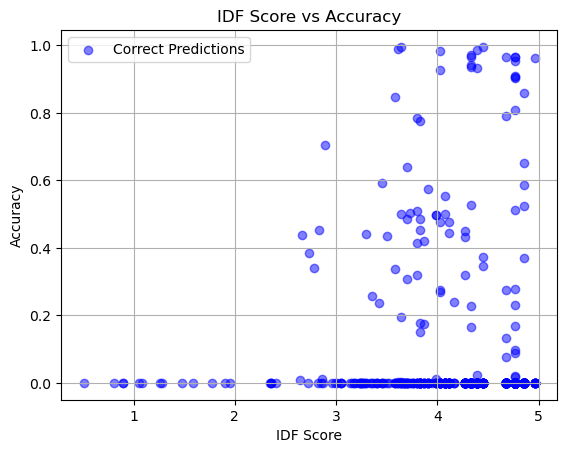

In [62]:

# Define the TF-IDF score threshold
idf_threshold = 0  # Adjust as needed

# Filter words based on TF-IDF score threshold
filtered_words = [word for word, idf in idf.items() if idf > idf_threshold]
filtered_idf_scores = [idf[word] for word in filtered_words]
filtered_correct_classifications = [stop_word_removal_Accuracy.get(word, 0) for word in filtered_words]

# Create figure and axes
fig, ax = plt.subplots()

# Plot correct predictions in blue
ax.scatter(filtered_tfidf_scores, filtered_correct_classifications, color='blue', alpha=0.5, label='Correct Predictions')


# Set labels and title
ax.set_xlabel('IDF Score')
ax.set_ylabel('Accuracy')
plt.title('IDF Score vs Accuracy')

# Customize the plot
plt.legend()
plt.grid(True)
plt.show()

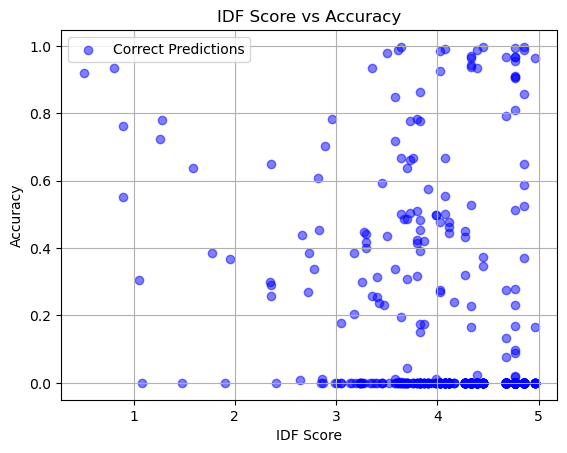

In [63]:

# Define the TF-IDF score threshold
idf_threshold = 0  # Adjust as needed

# Filter words based on TF-IDF score threshold
filtered_words = [word for word, idf in idf.items() if idf > idf_threshold]
filtered_idf_scores = [idf[word] for word in filtered_words]
filtered_correct_classifications = [Accuracy.get(word, 0) for word in filtered_words]

# Create figure and axes
fig, ax = plt.subplots()

# Plot correct predictions in blue
ax.scatter(filtered_tfidf_scores, filtered_correct_classifications, color='blue', alpha=0.5, label='Correct Predictions')


# Set labels and title
ax.set_xlabel('IDF Score')
ax.set_ylabel('Accuracy')
plt.title('IDF Score vs Accuracy')

# Customize the plot
plt.legend()
plt.grid(True)
plt.show()

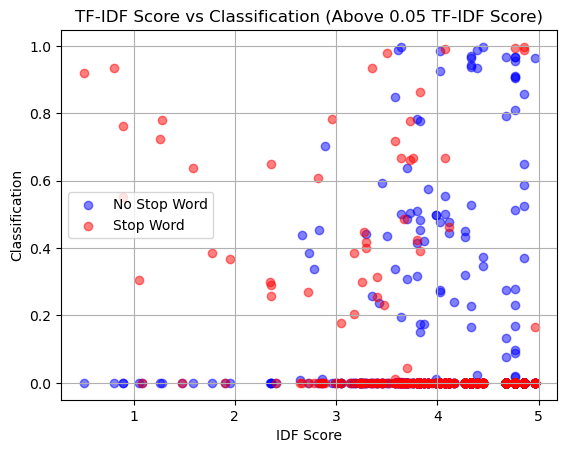

In [64]:
idf_threshold = 0.05  # Adjust as needed

# Filter words based on TF-IDF score threshold
filtered_words = [word for word, idf in idf.items() if idf > idf_threshold]
filtered_tfidf_scores = [idf[word] for word in filtered_words]
stop_word_removal_Accuracy = [stop_word_removal_Accuracy.get(word, 0) for word in filtered_words]
stop_words_accuracy = [stop_words_accuracy.get(word, 0) for word in filtered_words]

# Create figure and axes
fig, ax = plt.subplots()

# Plot correct predictions in blue
ax.scatter(filtered_tfidf_scores, stop_word_removal_Accuracy, color='blue', alpha=0.5, label='No Stop Word')

# Plot incorrect predictions in red
ax.scatter(filtered_tfidf_scores, stop_words_accuracy, color='red', alpha=0.5, label='Stop Word')

# Set labels and title
ax.set_xlabel('IDF Score')
ax.set_ylabel('Classification')
plt.title('TF-IDF Score vs Classification (Above {} TF-IDF Score)'.format(idf_threshold))

# Customize the plot
plt.legend()
plt.grid(True)
plt.show()